In [ ]:
![ -e 'zip.train' ] || ( wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz && gzip -d zip.train.gz )
![ -e 'zip.test' ] || ( wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz && gzip -d zip.test.gz )

Import necessary packages: Numpy, Pandas, matplotlib

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Mount your google drive (if you have a google account) or upload files (go on the file icon on the left -> right click). Copy path of zip.train and zip.test and load them as numpy arrays using the following code (insert the path as string).

In [ ]:
#dirname = '/content/drive/My Drive/ML_Class_2020/KNN/'
dirname = './'
path_to_train = dirname + 'zip.train'
path_to_test = dirname + 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. Note the only difference is
# that we don't load as many ones as we load zeros.

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1][:30]
X_train = np.vstack((X_train_0, X_train_1))

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1][:30]
y_train = np.hstack((y_train_0, y_train_1))

X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1][:12]
X_test = np.vstack((X_test_0, X_test_1))

y_test_0 = y_test[y_test == 0]
y_test_1 = y_test[y_test == 1][:12]
y_test = np.hstack((y_test_0, y_test_1))
print(y_test.shape)

(371,)


In [ ]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 1-sample_digits[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')


(90,)


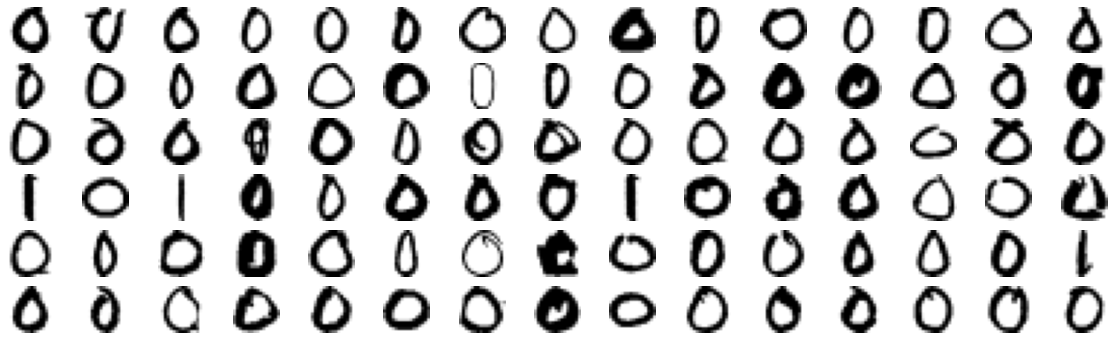

In [ ]:
show_numbers(X_test)

Choose one of the classifiers you implemented and use it on the following task: Take a look at the provided notebook. It loads the ZIP-Code’s zeros and ones, but now there are manymore zeros than there are ones. We are going to believe that these digits represent geneticdata. Actually, we are virologists trying to develop a test to determine which of the data belongs to infected patients (the ones) and which do not (the zeros). Train/apply your model on the data and do the tasks of the exercise.

In [ ]:
from collections import Counter
from functools import wraps, partial


def collect_after(c):
  def decorator(f):
    @wraps(f)
    def g(*args, **kwargs):
      return c(f(*args, **kwargs))
    return g
  return decorator


class KNearestNeighbors():
    '''
    Think about defining more functions that will help you building this algorithm.
    Optimally, one that takes in k and a test image as a parameter.
    '''
    def squared_euclidean_distance(self, x_1, x_2, axis=1):
      '''
      np.sum(x, axis = 1) will be summing all elements over the pixel dimension (axis = 1)
      '''
      return np.sum((x_1 - x_2) ** 2, axis=axis)
    
    def set_k(self, k):
      self.k = k
    
    def __init__(self, k):
      self.set_k(k)
    
    def fit(self, X, y):
      self.X = X
      self.y = y
    
    @collect_after(tuple)
    def calculate_nearest(self, X, k=None):
      if k is None:
        k = self.k
      for obj in X:
        nearest = []
        for i, known in enumerate(self.X):
          d = self.squared_euclidean_distance(known, obj, axis=0)
          nearest.append((d, i))
          nearest.sort()
          nearest[k:] = []
        yield tuple(nearest)
    
    @collect_after(partial(np.fromiter, dtype=float))
    def predict_class(self, X, nearest=None):
      res = []
      k = self.k
      if nearest is None:
        nearest = self.calculate_nearest(X, k)
      for nearest_current in nearest:
        yield Counter(self.y[i] for _, i in nearest_current[:k]).most_common(1)[0][0]
    
    def predict_class_different_k(self, X, ks=(3,)):
      ks = tuple(ks)
      nearest = self.calculate_nearest(X, max(ks))
      for k in ks:
        self.set_k(k)
        yield (k, self.predict_class(X, nearest=nearest))


def accuracy(y_actual, y_pred):
  return (y_actual == y_pred).sum() / len(y_actual)

In [ ]:
@collect_after(tuple)
def k_fold_split(X, y, k):
  n = len(y)
  permut = np.argsort(np.random.random_sample((n,)))
  X_s = X[permut]
  y_s = y[permut]
  for i in range(k):
    start, end = int(i * n / k), int((i + 1) * n / k)
    yield (X_s[start:end], y_s[start:end])

In [ ]:
class CrossValidation():
  def stack_pairs(self, pairs):
    return np.vstack([Xy[0] for Xy in pairs]), np.hstack([Xy[1] for Xy in pairs])

  def joins(self, samples):
    for i in range(len(samples)):
      yield (samples[i], self.stack_pairs(samples[:i] + samples[i + 1:]))

  def __init__(self, model_class, samples, params, loss):
    self.models = []
    self.train_val_splits = []
    losses = []
    for Xy_val, Xy_train in self.joins(samples):
      self.train_val_splits.append((Xy_train, Xy_val))
      model = model_class(**params)
      self.models.append(model)
      model.fit(*Xy_train)
      y_pred = model.predict_class(Xy_val[0])
      L = loss(Xy_val[1], y_pred)
      losses.append(L)
    self.losses = np.array(losses)
    self.bias = np.mean(self.losses)
    self.var = np.var(self.losses)

In [ ]:
def one_minus_accuracy(y_actual, y_pred):
  return 1.0 - accuracy(y_actual, y_pred)

In [ ]:
from itertools import product
def iter_params(spaces):
  names = spaces.keys()
  for values in product(*(spaces[k] for k in names)):
    yield dict(zip(names, values))

In [ ]:
def k_fold_search_params(model_class, X, y, k, spaces, loss):
  info = {**{'param_' + i: [] for i in spaces.keys()}, 'bias': [], 'var': []}
  splits = k_fold_split(X, y, k)
  for params in iter_params(spaces):
    cv = CrossValidation(model_class, splits, params, loss)
    info['bias'].append(cv.bias)
    info['var'].append(cv.var)
    for p, v in params.items():
      info['param_' + p].append(v)
  return pd.DataFrame(info)

In [ ]:
%%time
np.random.seed(42)
search_df = k_fold_search_params(KNearestNeighbors, X_train, y_train, 5, {'k': np.arange(1, 30, 1, dtype=int)}, one_minus_accuracy)

CPU times: user 5min 6s, sys: 57.8 ms, total: 5min 6s
Wall time: 5min 7s


In [ ]:
search_df

,param_k,bias,var
0,1,0.000000,0.000000
1,2,0.000000,0.000000
2,3,0.000000,0.000000
3,4,0.000000,0.000000
4,5,0.000000,0.000000
5,6,0.000000,0.000000
6,7,0.000000,0.000000
7,8,0.000000,0.000000
8,9,0.000000,0.000000
9,10,0.000000,0.000000


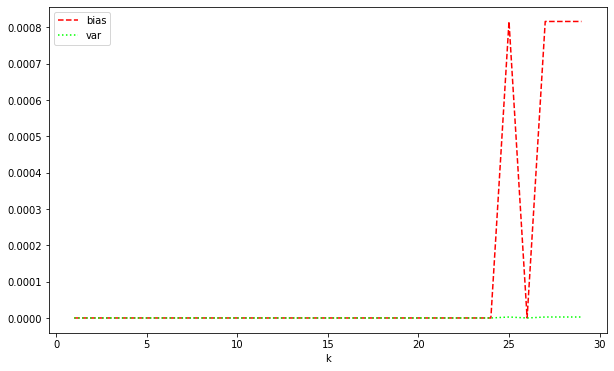

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(search_df['param_k'], search_df['bias'], linestyle='--', color='#FF0000', label='bias')
plt.plot(search_df['param_k'], search_df['var'], linestyle=':', color='#00FF00', label='var')
plt.xlabel('k')
plt.legend()
plt.show()

The model seems to almost always give the correct answer on the training dataset.


In [ ]:
from collections import namedtuple
from functools import lru_cache

class Confusion(namedtuple('Confusion', ['TP', 'FP', 'FN', 'TN'])):
  def calculate(y_true, y_pred):
    y_true = y_true == True
    y_pred = y_pred == True
    return Confusion((y_true & y_pred).sum(), (~y_true & y_pred).sum(),
                     (y_true & ~y_pred).sum(), (~y_true & ~y_pred).sum())
  
  @property
  def P(self):
    return self.TP + self.FN
  
  @property
  def N(self):
    return self.FP + self.TN
  
  @property
  def PP(self):
    return self.TP + self.FP
  
  @property
  def PN(self):
    return self.FN + self.TN
  
  # Precision
  @property
  @lru_cache()
  def PPV(self):
    return self.TP / self.PP
  
  # Recall
  @property
  @lru_cache()
  def TPR(self):
    return self.TP / self.P

  @property
  def F1(self):
    return 2 / (1 / self.TPR + 1 / self.PPV)
  
  @property
  def accuracy(self):
    return (self.TP + self.TN) / (self.P + self.N)

In [ ]:
%%time
model = KNearestNeighbors(k=3)
model.fit(X_train, y_train)
conf = Confusion.calculate(y_test, model.predict_class(X_test))

CPU times: user 3.6 s, sys: 998 µs, total: 3.6 s
Wall time: 3.6 s


In [ ]:
conf

Confusion(TP=12, FP=1, FN=0, TN=358)

In [ ]:
def print_scores(conf):
  print(f"""
Precision: {conf.PPV:.3}
Recall: {conf.TPR:.3}
F1-score: {conf.F1:.3}
Accuracy: {conf.accuracy:.3}
""")

In [ ]:
print_scores(conf)


Precision: 0.923
Recall: 1.0
F1-score: 0.96
Accuracy: 0.997



In [ ]:
conf_zeros = Confusion.calculate(y_test, np.zeros_like(y_test))
print_scores(conf_zeros)


Precision: nan
Recall: 0.0
F1-score: nan
Accuracy: 0.968



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


Precision is not defined, because we have never classified objects as positive, but F1 would be 0 in similar cases.

Precision only says the proportion of correct answers.
F1-score shows, how the nodel actually is at distinguishing the two classes.

According to the given test dataset, the probability is $92%$.
Yes, I would.

But even if the probabilities had been less, using the test could be recommended depending on the cost of the two types of error,